In [52]:
import numpy as np
from epyt import epanet

from esc.water_usage import MINUTES_PER_DAY, TYPICAL_BUILDING_MEAN_WATER_CONSUMPTION_LITER_PER_MINUTE, relative_occupant_water_demand

In [53]:
d = epanet("../networks/BUILDING.inp")

EPANET version 20200 loaded (EPyT version 1.0.1).
Input File BUILDING.inp loaded successfully.



In [54]:
SIMULATION_DURATION_S = 172800

In [55]:
d.setTimeSimulationDuration(SIMULATION_DURATION_S) # 48 hour duration
d.setTimeHydraulicStep(60) # Time step every minute
d.setTimePatternStep(60) # Pattern step every minute

In [56]:
# Add time-dependent pattern for occupant demand to the outflow junction
# Sample the demand for every minute of the day
demand_sample_24h = relative_occupant_water_demand(np.arange(MINUTES_PER_DAY))
d.addPattern("relative_occupant_demand", demand_sample_24h)
d.setNodeJunctionData(1, 0, TYPICAL_BUILDING_MEAN_WATER_CONSUMPTION_LITER_PER_MINUTE, 'relative_occupant_demand')

In [57]:
# Taken from https://www.coned.com/en/accounts-billing/your-bill/time-of-use
EIGHT_AM_MINUTES = 8 * 60
off_peak_rates = np.ones(EIGHT_AM_MINUTES) * 0.018
peak_rates = np.ones(MINUTES_PER_DAY - EIGHT_AM_MINUTES) * 0.255
all_rates = np.concatenate((off_peak_rates, peak_rates), axis=None)
d.setOptionsGlobalPattern(d.addPattern("electricity_price", all_rates))

In [58]:
res = d.getComputedHydraulicTimeSeries()

In [59]:
d.deleteControls()
tankID = 'T1'
pumpID = 'PUMP'

tankIndex = d.getNodeIndex(tankID)
pumpIndex = d.getLinkIndex(pumpID)
tankElevation = d.getNodeElevations(tankIndex)

# Hydraulic analysis STEP-BY-STEP.
d.openHydraulicAnalysis()
d.initializeHydraulicAnalysis(0)

tstep = 1
i = 0
T, P, F, S, E = [], [], [], [], []

# CONTROLS.
Below = 1.0
Above = 2.0
tankHead = []
while tstep > 0:

    H = d.getNodeHydraulicHead()
    tankHead.append(H[tankIndex - 1] - tankElevation)

    # Add new controls in live.
    # LINK 9 OPEN IF NODE 2 BELOW 110
    # if tankHead[i] < Below:
    #     d.setLinkStatus(pumpIndex, 1)
    # # LINK 9 CLOSED IF NODE 2 ABOVE 140
    # if tankHead[i] > Above:
    #     d.setLinkStatus(pumpIndex, 0)
    i += 1

    t = d.runHydraulicAnalysis()

    S.append(d.getLinkStatus(pumpIndex))
    F.append(d.getLinkFlows())
    P.append(d.getNodePressure())
    E.append(d.getLinkEnergy(pumpIndex))
    T.append(t)

    tstep = d.nextHydraulicAnalysisStep()

d.closeHydraulicAnalysis()
print("Hydraulic Analysis completed succesfully.")

Hydraulic Analysis completed succesfully.


/opt/homebrew/Caskroom/mambaforge/base/envs/engineering-smart-cities/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


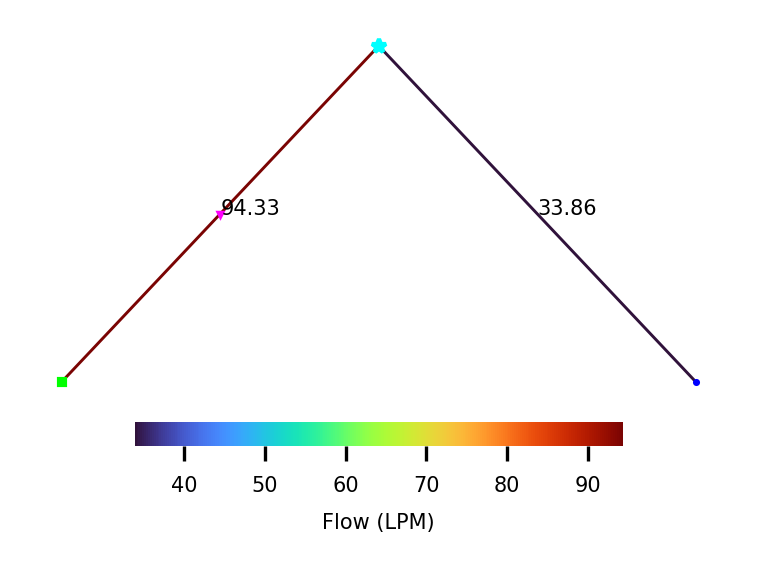

In [60]:
_ = d.plot(flow=F[48], flow_text=True)

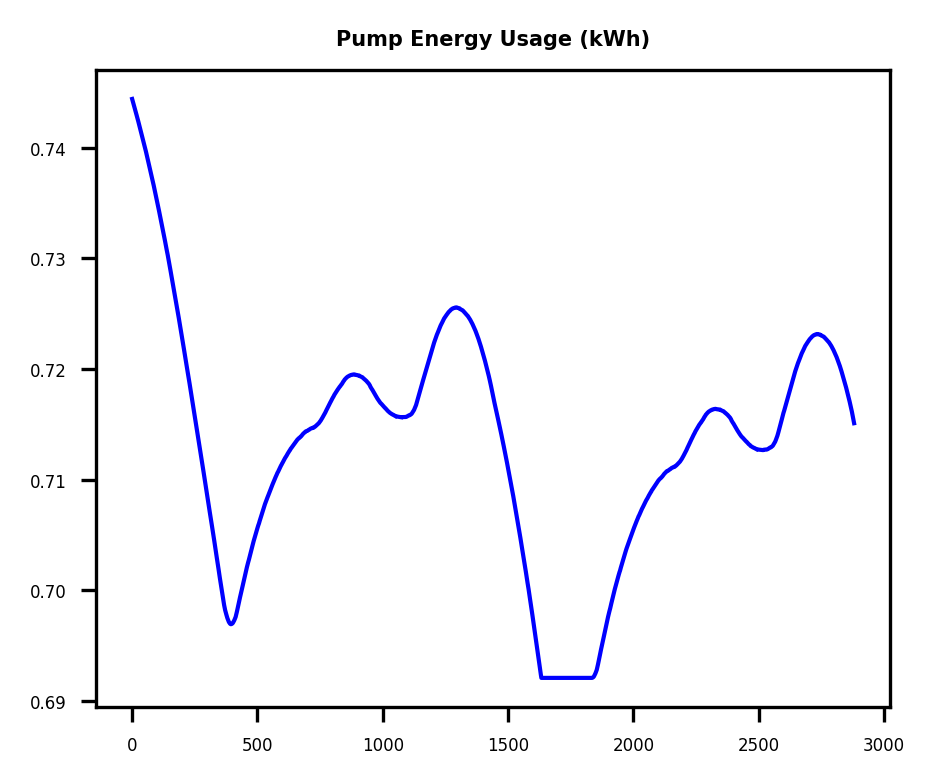

In [61]:
d.plot_ts(Y=E, title="Pump Energy Usage (kWh)", marker=False)

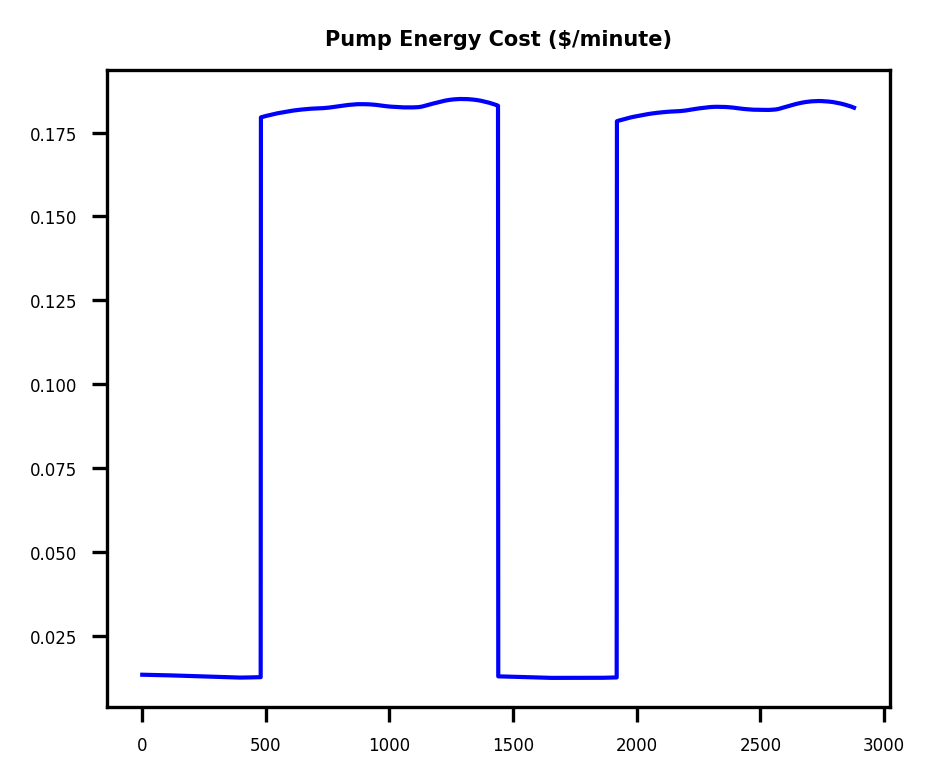

In [68]:
d.plot_ts(Y=np.array(E[:-2]) * np.concatenate((all_rates, all_rates), axis=None), title="Pump Energy Cost ($/minute)", marker=False)

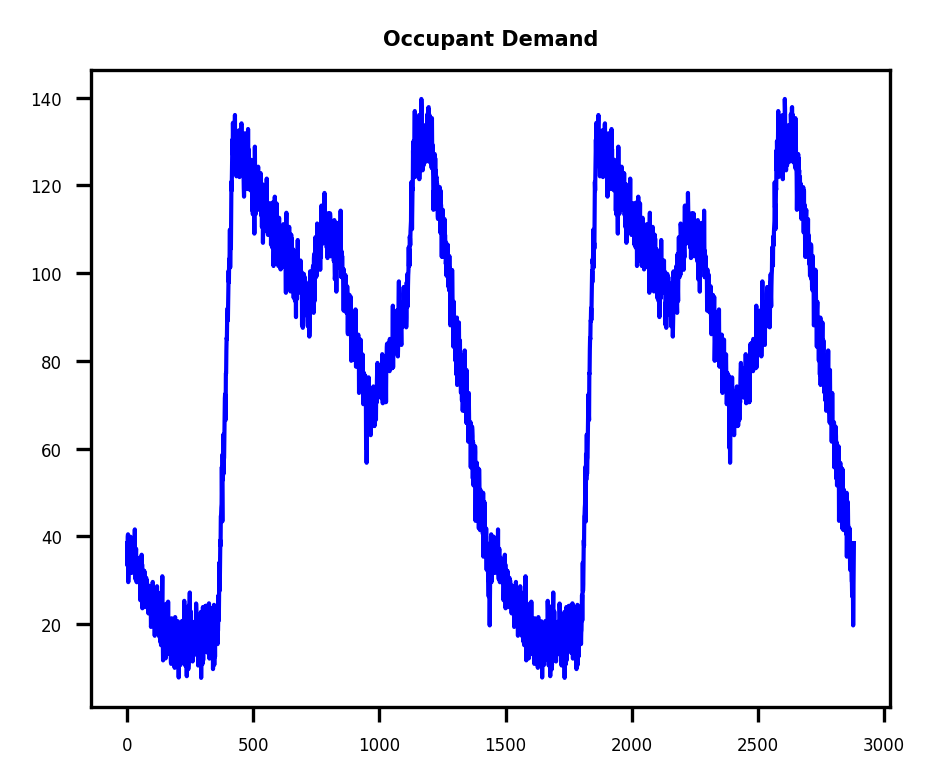

In [62]:
d.plot_ts(Y=np.array(F)[:, 0], title="Occupant Demand", marker=False)

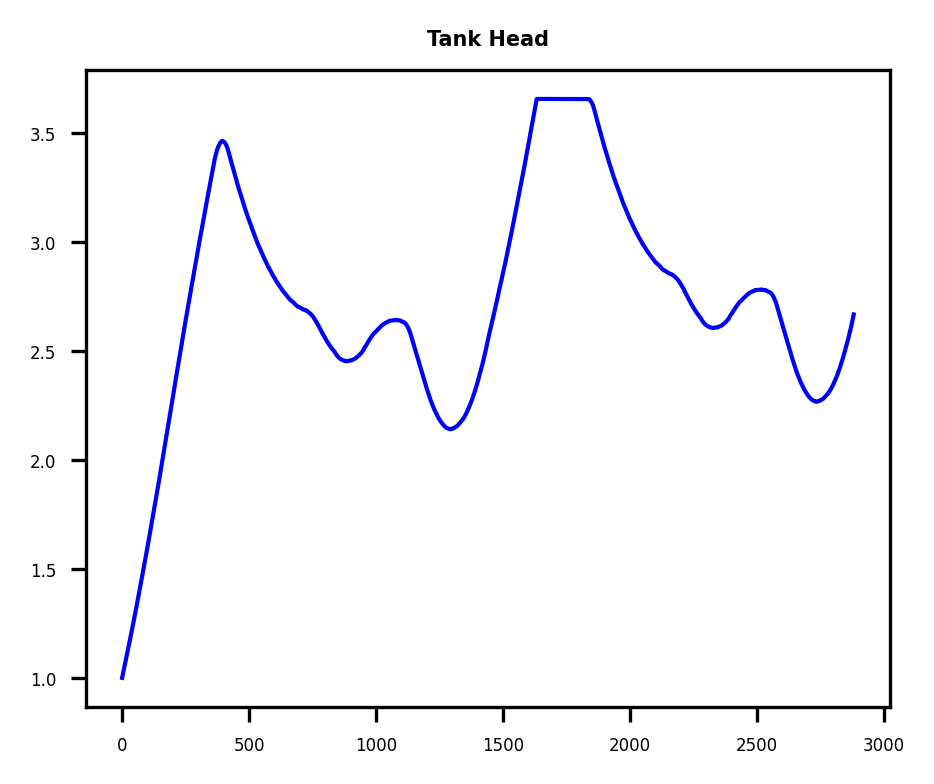

In [63]:
d.plot_ts(Y=tankHead, title='Tank Head', marker=False)